Feature Extraction script - input time series raw acclerometer data, extract features in window with overalpping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Change this directory to the location of the shared 1004.csv file after mounting your Drive to the Colab
savedir = "/content/drive/My Drive/CA683_Assignment-2/Data/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Prior to running this script, please add a shortcut of the shared data folder containing the sample measurement files provided and extracted feature set to your Google Drive (right click on the folder in question, and then click "Add shortcut to Drive")

# Load Libraries

In [2]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import sys
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter_zi, lfilter, freqz
from scipy.signal import freqz
from scipy import signal
from scipy.stats import kurtosis, skew
from scipy.signal import argrelextrema
from scipy.integrate import simps
import scipy.signal as sg
from scipy.ndimage.filters import generic_filter
from scipy import stats
import glob
from tqdm import tqdm
from IPython.display import clear_output
import time
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
import IPython
from scipy.signal import find_peaks
init_notebook_mode(connected=True) # initiate notebook for offline plot
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Signal functions

##Filters

In [0]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

##Bandpower

In [0]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp, freqs, psd

#Load path

In [0]:
clear = lambda: os.system('cls')
fd = os.open(os.devnull, os.O_RDWR)
# NB: even if stdin is closed, fd >= 0
os.dup2(fd, 1)
os.dup2(fd, 2)
if fd > 2:
  os.close(fd)
#Process all users in a loop - checks for processed files if it crashes
files = [f for f in listdir(savedir) if isfile(join(savedir, f))]
files_user = [f for f in listdir(savedir) if isfile(join(savedir, f))]

#EDA

In [0]:
user = 1004 #User number
df = pd.read_csv(savedir + str(user) + '.csv')

## Raw data

In [7]:
#RAW dataframe
columns_raw = ['Timestamp','X','Y', 'Z', 'measurement_id']
df_raw = df[columns_raw]
df_raw.head()

,Timestamp,X,Y,Z,measurement_id
0,0.00,-1.090332,-0.237793,0.395508,cc7b822c-e310-46f0-a8ea-98c95fdb67a1
1,0.02,-1.267822,-0.102051,0.172852,cc7b822c-e310-46f0-a8ea-98c95fdb67a1
2,0.04,-1.185791,-0.089600,0.017090,cc7b822c-e310-46f0-a8ea-98c95fdb67a1
3,0.06,-1.176270,-0.077637,-0.002197,cc7b822c-e310-46f0-a8ea-98c95fdb67a1
4,0.08,-1.211670,-0.013672,-0.079590,cc7b822c-e310-46f0-a8ea-98c95fdb67a1


This is an example of the provided measurement data from the challenge

In [8]:
#Merged sensor data with HAR time series features and target labels to allow for easier feature extraction and modeeling
#columns = ['Timestamp','X','Y', 'Z', 'measurement_id', 'subject_id','on_off', 'dyskinesia', 'tremor']
df = df[df.columns.drop(list(df.filter(regex='Row')))]
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
df.head()

,Timestamp,measurement_id,Reading,X,Y,Z,Gravity_X,Gravity_Y,Gravity_Z,Acc_X,Acc_Y,Acc_Z,Mag_Acc,Angle_X,Angle_Y,Angle_Z,Activity_Label,subject_id,on_off,dyskinesia,tremor
0,0.00,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1,-1.090332,-0.237793,0.395508,-0.575282,-0.053844,0.091200,-0.000004,-3.473965e-07,5.884131e-07,102.00000,79.568720,5.281506,8.969638,Light,1004,1.0,1.0,1.0
1,0.02,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1,-1.267822,-0.102051,0.172852,-1.338952,-0.120607,0.204281,-0.000031,-2.836341e-06,4.804137e-06,101.99694,79.676999,5.227129,8.876799,Light,1004,1.0,1.0,1.0
2,0.04,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1,-1.185791,-0.089600,0.017090,-1.191176,-0.094361,0.088770,-0.000124,-1.128992e-05,1.866419e-05,101.98674,80.001681,5.155596,8.543218,Light,1004,1.0,1.0,1.0
3,0.06,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1,-1.176270,-0.077637,-0.002197,-1.113940,-0.074397,-0.032633,-0.000338,-3.024008e-05,4.748036e-05,101.96532,80.539578,5.065631,7.968926,Light,1004,1.0,1.0,1.0
4,0.08,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1,-1.211670,-0.013672,-0.079590,-1.275475,-0.049545,-0.002294,-0.000725,-6.323692e-05,9.247745e-05,101.92554,81.216096,4.944884,7.241671,Light,1004,1.0,1.0,1.0


In [0]:
#Determine sample freq of sensor - either 50 or 100 Hz
if df.Timestamp[75] > 1.0:
  fs = 50
else:
  fs = 100

# Sample rate and desired cutoff frequencies for bandpass filtering(in Hz).
fs = 50
lowcut = 3.5
highcut = 7.5

In [0]:
#Explore the dataframe with a feature and associated severity level
symptom = 'tremor'
severity = 4.0
meas_samp = df[symptom][df[symptom] == severity].index.tolist()[0] # find idex of condition
#Find a matching measurement id to filter the dataframe
meas_samp = df.measurement_id[meas_samp]
#Subset of dataframe from measurement matching above conditions
df1 = df.loc[df['measurement_id'] == str(meas_samp)]


In [0]:
#or select a speicifc measurement file
meas_samp = 'daf11494-e6fa-4376-a78a-86c683885764'
#Subset of dataframe from measurement matching above conditions
df1 = df.loc[df['measurement_id'] == str(meas_samp)]

## Peak detection

Num peaks every 50Hz in x axis: 7


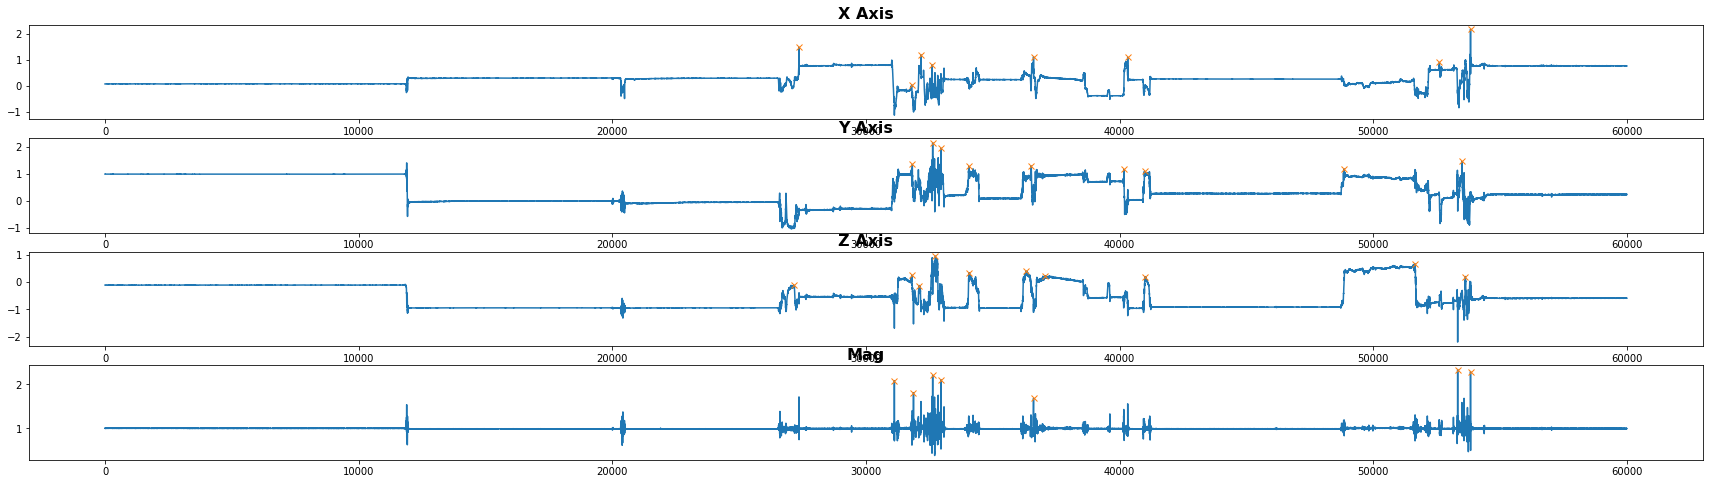

In [12]:
series1_x = df1['X']
series1_y = df1['Y']
series1_z = df1['Z']

#Finding peaks of signal
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html 

vector_x = np.array(series1_x)
vector_y = np.array(series1_y)
vector_z = np.array(series1_z)

#Magnitude of acceleration vector
A=np.sqrt(vector_x**2+vector_y**2+vector_z**2)

peaksx, _ =  sg.find_peaks(vector_x, prominence=(1,20),distance=50*5)
peaksy, _ =  sg.find_peaks(vector_y, prominence=(1,20),distance=50*5)
peaksz, _ =  sg.find_peaks(vector_z, prominence=(1,20),distance=50*5)
peaksa, _ =  sg.find_peaks(A, prominence=(1,20),distance=50*5)

print('Num peaks every 50Hz in x axis: ' + str(len(peaksa)))

fig, (ax1,ax2, ax3, ax4) = plt.subplots(4,figsize=(30,8))
ax1.set_title('X Axis', fontsize= 16, fontweight="bold")
ax1.plot(vector_x)
ax1.plot(peaksx, vector_x[peaksx], "x")
ax2.set_title('Y Axis', fontsize= 16, fontweight="bold")
ax2.plot(vector_y)
ax2.plot(peaksy, vector_y[peaksy], "x")
ax3.set_title('Z Axis', fontsize= 16, fontweight="bold")
ax3.plot(vector_z)
ax3.plot(peaksz, vector_z[peaksz], "x")
ax4.set_title('Mag', fontsize= 16, fontweight="bold")
ax4.plot(A)
ax4.plot(peaksa, A[peaksa], "x")

8512

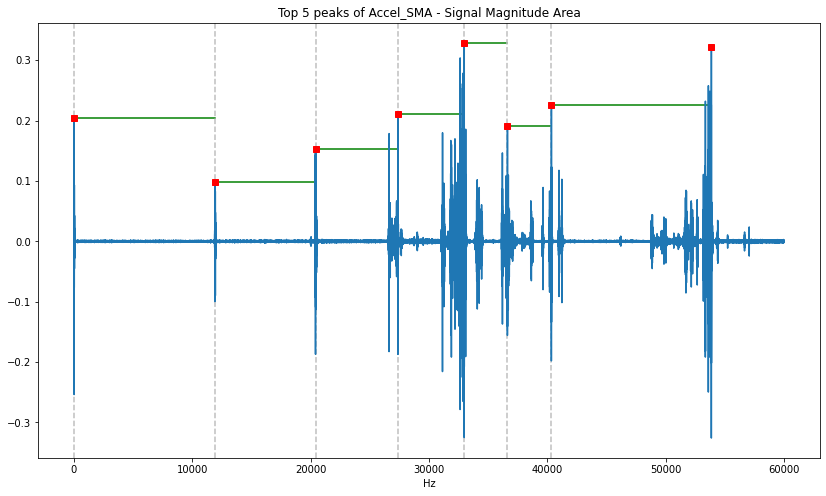

In [13]:
#Distaces between top 5 peaks
from matplotlib.pyplot import *

A_BP = butter_bandpass_filter(A, lowcut, highcut, fs, order=6)
std_A_BP = np.std(A_BP)
peaksA_BP, indsA_BP = find_peaks(A_BP, height=std_A_BP*3, distance=50*60)
indsA_BP = indsA_BP['peak_heights']
distances_A_BP = np.diff(peaksA_BP)

for i in range(len(distances_A_BP)):
    plot([peaksA_BP[i], peaksA_BP[i] + distances_A_BP[i]], 2*[indsA_BP[i]], color = 'g')
    axvline(peaksA_BP[i], linestyle='--', color='0.75')
plot(A_BP)
plot(peaksA_BP, indsA_BP, 'rs')
plt.title('Top 5 peaks of Accel_SMA - Signal Magnitude Area')
plt.xlabel('Hz')
distances_A_BP
np.var(peaksA_BP)
distances_A_BP[1]

## Skew & Kurtosis

In [14]:
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( round(kurtosis(vector_x),2)))
print( 'skewness of normal distribution (should be 0): {}'.format(round(skew(vector_x),2)))
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( round(kurtosis(vector_y),2 )))
print( 'skewness of normal distribution (should be 0): {}'.format( round(skew(vector_y),2 )))
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( round(kurtosis(vector_z),2 )))
print( 'skewness of normal distribution (should be 0): {}'.format( round(skew(vector_z),2) ))

excess kurtosis of normal distribution (should be 0): 0.68
skewness of normal distribution (should be 0): 0.11
excess kurtosis of normal distribution (should be 0): -1.02
skewness of normal distribution (should be 0): 0.14
excess kurtosis of normal distribution (should be 0): -0.44
skewness of normal distribution (should be 0): 0.8


##Filtering

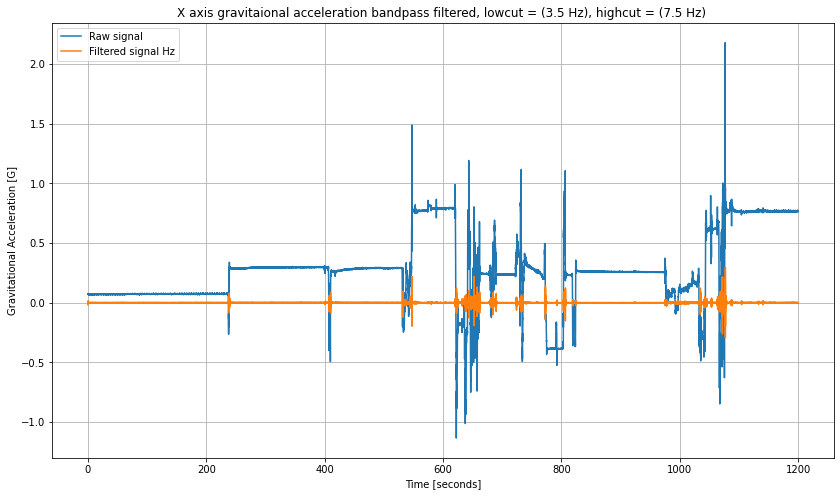

In [15]:
x = vector_x
T = len(x)/fs

nsamples = T * fs
t = np.linspace(0, T, len(x), endpoint=False)

#dur = range(30000, 30500)
dur = range(0, len(x))
plt.figure(2)
plt.clf()
plt.plot(t[dur], x[dur], label='Raw signal')


y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
std_y =np.std(y)
plt.title('X axis gravitaional acceleration bandpass filtered, lowcut = (%g Hz)' %lowcut + ', highcut = (%g Hz) ' %highcut)
plt.plot(t[dur], y[dur], label='Filtered signal Hz')
plt.xlabel('Time [seconds]')
plt.ylabel('Gravitational Acceleration [G]')
#plt.hlines([-std_y*3, std_y*3], dur[0]/50, dur[-1]/50, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

#### Butterworth

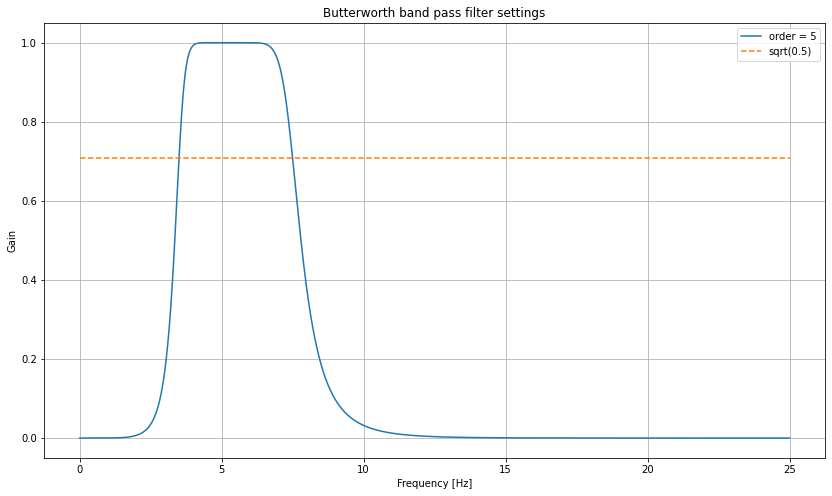

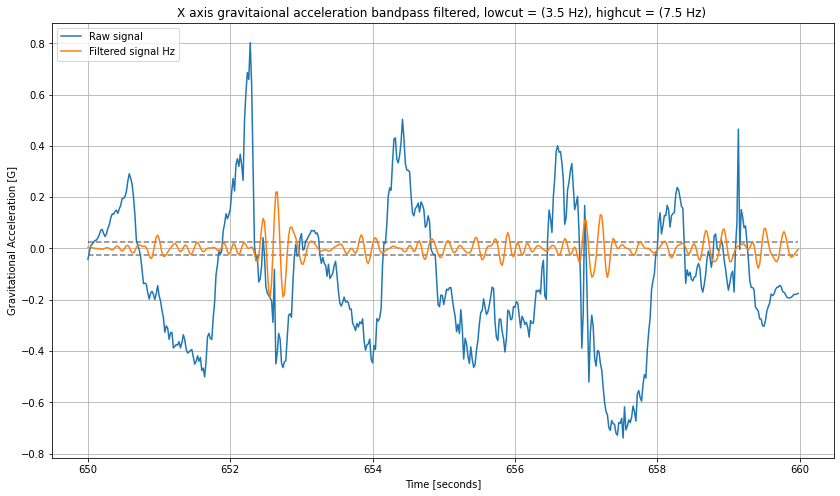

In [16]:
#
# Plot the frequency response for a few different orders.
dur = range(32500, 33000) # range in Hz to plot

plt.figure(1)
plt.clf()
plt.title('Butterworth band pass filter settings')
for order in [5]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
          '--', label='sqrt(0.5)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.figure(2)
plt.clf()
plt.plot(t[dur], x[dur], label='Raw signal')
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
std_y =np.std(y)
plt.title('X axis gravitaional acceleration bandpass filtered, lowcut = (%g Hz)' %lowcut + ', highcut = (%g Hz) ' %highcut)
#plt.title('f model: T=%i' %lowcut)
plt.plot(t[dur], y[dur], label='Filtered signal Hz')
plt.xlabel('Time [seconds]')
plt.ylabel('Gravitational Acceleration [G]')
plt.hlines([-std_y*3, std_y*3], dur[0]/50, dur[-1]/50, linestyles='--',alpha=0.5)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

## PSD and max frequency

Highest PSD frequency: 5.5


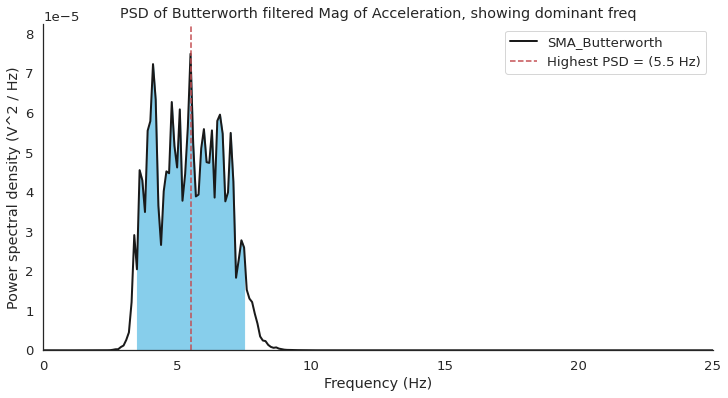

In [23]:
#https://raphaelvallat.com/bandpower.html 
# Define window length (4 seconds)
win = 10 * fs

#Adjust band filter 
lowcut = 3.5
highcut = 7.5
A_BP = butter_bandpass_filter(A, lowcut, highcut, fs, order=6)

freqs, psd = signal.welch(A_BP, fs, nperseg=win)
index_max = np.argmax(psd)
print('Highest PSD frequency: ' +str(freqs[index_max]))
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(12, 6))
plt.plot(freqs, psd, color='k', lw=2, label='SMA_Butterworth')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
plt.axvline(freqs[index_max], ymin=0, color='r', linestyle='dashed',label='Highest PSD = (%s Hz)' %freqs[index_max])
plt.legend()
plt.title('PSD of Butterworth filtered Mag of Acceleration, showing dominant freq')
sns.despine()

### Bandpower

Absolute delta power in band (blue) : 0.000 uV^2
Relative delta power: 0.913 


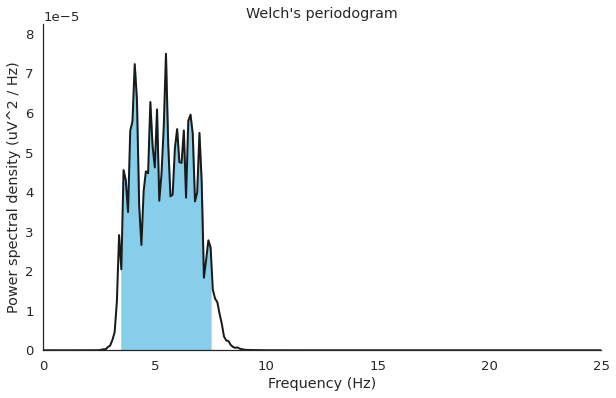

In [21]:
# Define delta lower and upper limits
low, high = lowcut,highcut

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(10, 6))
plt.plot(freqs, psd, lw=2, color='k',label='SMA_Butterworth')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, freqs.max()])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power in band (blue) : %.3f uV^2' % delta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f ' % delta_rel_power)

# Digital signal Processing - DSP

In [0]:
def ent(data):
    """Calculates entropy of the passed `pd.Series`
    """
    data = pd.Series(data)
    p_data = data.value_counts()           # counts occurrence of each value
    entropy = stats.entropy(p_data)  # get entropy from counts
    return entropy

def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    #assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)])) #assert statement is there to both check the calculation and to document its intent
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array

    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    #if window_sec is not None:
    #    nperseg = window_sec * sf
    #else:
    #    nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=window_sec)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp, freqs, psd


def custom_feature_extraction(df, fs, win):
  series_x = df['Acc_X']
  series_y = df['Acc_Y']
  series_z = df['Acc_Z']
  gravity_x = df['Gravity_X']
  gravity_y = df['Gravity_Y']
  gravity_z = df['Gravity_Z']
  angle_x = df['Angle_X']
  angle_y = df['Angle_Y']
  angle_z = df['Angle_Z']
  try:
    y_on_off = df['on_off']
    y_trem = df['tremor']
    y_dys = df['dyskinesia']
  except:
    c = 0
  timestamp = np.array(df['Timestamp'])
  EMAO = df['Mag_Acc']
  freqs, psd = signal.welch(EMAO, fs, nperseg=win)
  index_max = np.argmax(psd) #Max PSD
  

  feature_dict = {}
  
  try:
    feature_dict['on_off'] = stats.mode(df['on_off'])[0][0].astype('float')
    feature_dict['tremor'] = stats.mode(df['tremor'])[0][0].astype('float')
    feature_dict['dyskinesia'] = stats.mode(df['dyskinesia'])[0][0].astype('float')
  except:
    c=0
  feature_dict['Timestamp'] = df['Timestamp']
  feature_dict['Reading'] = df['Reading']
  feature_dict['measurement_id'] = df['measurement_id']#.where(df['Reading']==reading)
  feature_dict['subject_id'] = df['subject_id']
  feature_dict['X'] = series_x
  feature_dict['Y'] = series_z
  feature_dict['Z'] = series_z
  feature_dict['Gravity_X'] = df['Gravity_X']
  feature_dict['Gravity_Y'] = df['Gravity_Y']
  feature_dict['Gravity_Z'] = df['Gravity_Z']
  feature_dict['Angle_X'] = df['Angle_X']
  feature_dict['Angle_Y'] = df['Angle_Y']
  feature_dict['Angle_Z'] = df['Angle_Z']

  AutoC_x = estimated_autocorrelation(series_x)
  AutoC_y = estimated_autocorrelation(series_y)
  AutoC_z = estimated_autocorrelation(series_z)
  AutoC_gravity_x = estimated_autocorrelation(gravity_x)
  AutoC_gravity_y = estimated_autocorrelation(gravity_y)
  AutoC_gravity_z = estimated_autocorrelation(gravity_z)
  AutoC_angle_x = estimated_autocorrelation(angle_x)
  AutoC_angle_y = estimated_autocorrelation(angle_y)
  AutoC_angle_z = estimated_autocorrelation(angle_z)

  feature_dict['X-AutoCorrelation'] = AutoC_x
  feature_dict['Y-AutoCorrelation'] = AutoC_y
  feature_dict['Z-AutoCorrelation'] = AutoC_z
  feature_dict['GravityX-AutoCorrelation'] = AutoC_gravity_x
  feature_dict['GravityY-AutoCorrelation'] = AutoC_gravity_y
  feature_dict['GravityZ-AutoCorrelation'] = AutoC_gravity_z
  feature_dict['AngleX-AutoCorrelation'] = AutoC_angle_x
  feature_dict['AngleY-AutoCorrelation'] = AutoC_angle_y
  feature_dict['AngleZ-AutoCorrelation'] = AutoC_angle_z

  #Magnitude Acceleration as dot product
  SMA = np.sqrt(series_x**2 + series_y**2 + series_z**2)
  #Standard Deviation
  std_x = np.std(series_x)
  std_y = np.std(series_y)
  std_z = np.std(series_z)
  std_AutoC_x = np.std(AutoC_x)
  std_AutoC_y = np.std(AutoC_y)
  std_AutoC_z = np.std(AutoC_z)
  std_SMA = np.std(SMA)
  std_EMAO = np.std(EMAO)
  #Calculate Peaks
  peaks_x, _ =  sg.find_peaks(series_x, height=std_x*3 ,distance=50)
  peaks_y, _ =  sg.find_peaks(series_y, height=std_y*3,distance=50)
  peaks_z, _ =  sg.find_peaks(series_z, height=std_z*3,distance=50)

  peaks_AutoC_x, _ =  sg.find_peaks(AutoC_x, height=std_AutoC_x*3 ,distance=50)
  peaks_AutoC_y, _ =  sg.find_peaks(AutoC_y, height=std_AutoC_y*3 ,distance=50)
  peaks_AutoC_z, _ =  sg.find_peaks(AutoC_z, height=std_AutoC_z*3 ,distance=50)

  peaks_A, _ =  sg.find_peaks(SMA, height=std_SMA*3,distance=50)
  peaks_B, _ =  sg.find_peaks(EMAO, height=std_EMAO*3,distance=50)
  peaks_B_EMAO, indsB_EMAO =  sg.find_peaks(EMAO)

  X_filt = np.array(generic_filter(series_x, np.std, size=3))
  Y_filt = np.array(generic_filter(series_y, np.std, size=3))
  Z_filt = np.array(generic_filter(series_z, np.std, size=3))
  AutoC_X_filt = np.array(generic_filter(AutoC_x, np.std, size=3))
  AutoC_Y_filt = np.array(generic_filter(AutoC_y, np.std, size=3))
  AutoC_Z_filt = np.array(generic_filter(AutoC_z, np.std, size=3))

  A_filt = np.array(generic_filter(SMA, np.std, size=3))
  B_filt = np.array(generic_filter(EMAO, np.std, size=3))

  AVG_BP_SMA_p5_to_3p5Hz, freqs_p5_3p5_SMA, psd_p5_3p5_SMA = bandpower(SMA, fs, [0.5, 3.5], window_sec=win-1, relative=False)
  AVG_BP_SMA_1_to_3Hz, freqs_1_3_SMA, psd_1_3_SMA = bandpower(SMA, fs, [1, 3], window_sec=win-1, relative=False)
  AVG_BP_SMA_3_to_7Hz, freqs_3_7_SMA, psd_3_7_SMA = bandpower(SMA, fs, [3, 7], window_sec=win-1, relative=False)
  AVG_BP_SMA_1_to_10Hz, freqs_1_10_SMA, psd_1_10_SMA = bandpower(SMA, fs, [1, 10], window_sec=win-1, relative=False)
  AVG_BP_SMA_3_to_10Hz, freqs_3_10_SMA, psd_3_10_SMA = bandpower(SMA, fs, [3, 10], window_sec=win-1, relative=False)
  
  #EMAO
  AVG_BP_EMAO_p5_to_3p5Hz, freqs_p5_3p5_EMAO, psd_p5_3p5_EMAO = bandpower(EMAO, fs, [0.5, 3.5], window_sec=win-1, relative=False)
  AVG_BP_EMAO_1_to_3Hz, freqs_1_3_EMAO, psd_1_3_EMAO = bandpower(EMAO, fs, [1, 3], window_sec=win-1, relative=False)
  AVG_BP_EMAO_3_to_7Hz, freqs_3_7_EMAO, psd_3_7_EMAO = bandpower(EMAO, fs, [3, 7], window_sec=win-1, relative=False)
  AVG_BP_EMAO_1_to_10Hz, freqs_1_10_EMAO, psd_1_10_EMAO = bandpower(EMAO, fs, [1, 10], window_sec=win-1, relative=False)
  AVG_BP_EMAO_3_to_10Hz, freqs_3_10_EMAO, psd_3_10_EMAO = bandpower(EMAO, fs, [3, 10], window_sec=win-1, relative=False)
  
  # Compute the absolute power by approximating the area under the curve
  idx_delta_p5_3p5_SMA = np.logical_and(freqs_p5_3p5_SMA >= 0.5, freqs_p5_3p5_SMA  <= 3.5)
  freq_res_p5_3p5_SMA = freqs_p5_3p5_SMA [1] - freqs_p5_3p5_SMA [0]  
  delta_power_p5_3p5_SMA = simps(psd_p5_3p5_SMA[idx_delta_p5_3p5_SMA], dx=freq_res_p5_3p5_SMA)
  total_power_p5_3p5_SMA  = simps(psd_p5_3p5_SMA, dx=freq_res_p5_3p5_SMA)
  delta_rel_power_p5_3p5_SMA  = delta_power_p5_3p5_SMA  / total_power_p5_3p5_SMA
  
  #
  idx_delta_1_3_SMA = np.logical_and(freqs_1_3_SMA >= 1, freqs_1_3_SMA <= 3)
  freq_res_1_3_SMA = freqs_1_3_SMA[1] - freqs_1_3_SMA[0]  
  delta_power_1_3_SMA = simps(psd_1_3_SMA[idx_delta_1_3_SMA], dx=freq_res_1_3_SMA)
  total_power_1_3_SMA  = simps(psd_1_3_SMA, dx=freq_res_1_3_SMA)
  delta_rel_power_1_3_SMA  = delta_power_1_3_SMA  / total_power_1_3_SMA
  
  # Compute the absolute power by approximating the area under the curve
  idx_delta_1_10_SMA = np.logical_and(freqs_1_10_SMA >= 1, freqs_1_10_SMA <= 10)
  freq_res_1_10_SMA = freqs_1_10_SMA[1] - freqs_1_10_SMA[0]    
  delta_power_1_10_SMA = simps(psd_1_10_SMA[idx_delta_1_10_SMA], dx=freq_res_1_10_SMA)
  total_power_1_10_SMA = simps(psd_1_10_SMA, dx=freq_res_1_10_SMA)
  delta_rel_power_1_10_SMA  = delta_power_1_10_SMA  / total_power_1_10_SMA
  
  # Compute the absolute power by approximating the area under the curve
  idx_delta_3_7_SMA = np.logical_and(freqs_3_7_SMA >= 1, freqs_3_7_SMA <= 10)
  freq_res_3_7_SMA = freqs_3_7_SMA[1] - freqs_3_7_SMA[0]    
  delta_power_3_7_SMA = simps(psd_3_7_SMA[idx_delta_3_7_SMA], dx=freq_res_3_7_SMA)
  total_power_3_7_SMA = simps(psd_3_7_SMA, dx=freq_res_3_7_SMA)
  delta_rel_power_3_7_SMA  = delta_power_3_7_SMA  / total_power_3_7_SMA

  # Compute the absolute power by approximating the area under the curve
  idx_delta_3_10_SMA = np.logical_and(freqs_3_10_SMA >= 1, freqs_3_10_SMA <= 10)
  freq_res_3_10_SMA = freqs_3_10_SMA[1] - freqs_3_10_SMA[0]    
  delta_power_3_10_SMA = simps(psd_3_7_SMA[idx_delta_3_10_SMA], dx=freq_res_3_10_SMA)
  total_power_3_10_SMA = simps(psd_3_7_SMA, dx=freq_res_3_10_SMA)
  delta_rel_power_3_10_SMA  = delta_power_3_10_SMA  / total_power_3_10_SMA

   # Compute the absolute power by approximating the area under the curve
  idx_delta_1_3_EMAO = np.logical_and(freqs_1_3_EMAO >= 1, freqs_1_3_EMAO <= 3)
  freq_res_1_3_EMAO = freqs_1_3_EMAO[1] - freqs_1_3_EMAO[0]  
  delta_power_1_3_EMAO = simps(psd_1_3_EMAO[idx_delta_1_3_EMAO], dx=freq_res_1_3_EMAO)
  total_power_1_3_EMAO  = simps(psd_1_3_EMAO, dx=freq_res_1_3_EMAO)
  delta_rel_power_1_3_EMAO  = delta_power_1_3_EMAO  / total_power_1_3_EMAO
  
  # Compute the absolute power by approximating the area under the curve
  idx_delta_1_10_EMAO = np.logical_and(freqs_1_10_EMAO >= 1, freqs_1_10_EMAO <= 10)
  freq_res_1_10_EMAO = freqs_1_10_EMAO[1] - freqs_1_10_EMAO[0]    
  delta_power_1_10_EMAO = simps(psd_1_10_EMAO[idx_delta_1_10_EMAO], dx=freq_res_1_10_EMAO)
  total_power_1_10_EMAO = simps(psd_1_10_EMAO, dx=freq_res_1_10_EMAO)
  delta_rel_power_1_10_EMAO  = delta_power_1_10_EMAO  / total_power_1_10_EMAO
  
  # Compute the absolute power by approximating the area under the curve
  idx_delta_3_7_EMAO = np.logical_and(freqs_3_7_EMAO >= 1, freqs_3_7_EMAO <= 10)
  freq_res_3_7_EMAO = freqs_3_7_EMAO[1] - freqs_3_7_EMAO[0]    
  delta_power_3_7_EMAO = simps(psd_3_7_EMAO[idx_delta_3_7_EMAO], dx=freq_res_3_7_EMAO)
  total_power_3_7_EMAO = simps(psd_3_7_EMAO, dx=freq_res_3_7_EMAO)
  delta_rel_power_3_7_EMAO  = delta_power_3_7_EMAO  / total_power_3_7_EMAO

  # Compute the absolute power by approximating the area under the curve
  idx_delta_3_10_EMAO = np.logical_and(freqs_3_10_EMAO >= 1, freqs_3_10_EMAO <= 10)
  freq_res_3_10_EMAO = freqs_3_10_EMAO[1] - freqs_3_10_EMAO[0]    
  delta_power_3_10_EMAO = simps(psd_3_7_EMAO[idx_delta_3_10_EMAO], dx=freq_res_3_10_EMAO)
  total_power_3_10_EMAO = simps(psd_3_7_EMAO, dx=freq_res_3_10_EMAO)
  delta_rel_power_3_10_EMAO  = delta_power_3_10_EMAO  / total_power_3_10_EMAO

  #
  idx_delta_p5_3p5_EMAO = np.logical_and(freqs_p5_3p5_EMAO >= 0.5, freqs_p5_3p5_EMAO <= 3.5)
  freq_res_p5_3p5_EMAO = freqs_p5_3p5_EMAO[1] - freqs_p5_3p5_EMAO[0]  
  delta_power_p5_3p5_EMAO = simps(psd_p5_3p5_EMAO[idx_delta_p5_3p5_EMAO], dx=freq_res_p5_3p5_EMAO)
  total_power_p5_3p5_EMAO = simps(psd_p5_3p5_EMAO, dx=freq_res_p5_3p5_EMAO)
  delta_rel_power_p5_3p5_EMAO  = delta_power_p5_3p5_EMAO  / total_power_p5_3p5_EMAO

  #AVG_x[str(data)] = abs(np.mean(series_x))
  feature_dict['AVG_x'] = abs(np.mean(series_x))
  #AVG_y[str(data)] = abs(np.mean(series_y))
  feature_dict['AVG_y'] = abs(np.mean(series_y))
  #AVG_z[str(data)] = abs(np.mean(series_z))
  feature_dict['AVG_z'] = abs(np.mean(series_z))
  
  # STD_x[str(data)] = abs(std_x)
  feature_dict['STD_x'] = abs(std_x)
  # STD_y[str(data)] = abs(std_y)
  feature_dict['STD_y'] = abs(std_y)
  # STD_z[str(data)] = abs(std_z)
  feature_dict['STD_z'] = abs(std_z)
  # RMS_x[str(data)] = np.sqrt(np.mean(series_x**2))
  feature_dict["RMS_x"] = np.sqrt(np.mean(series_x**2))
  # RMS_y[str(data)] = np.sqrt(np.mean(series_y**2))
  feature_dict["RMS_y"] = np.sqrt(np.mean(series_y**2))
  # RMS_z[str(data)] = np.sqrt(np.mean(series_z**2))
  feature_dict["RMS_z"] = np.sqrt(np.mean(series_z**2))
  # MinMax_x[str(data)] = (max(series_x) - min(series_x))  
  feature_dict['MinMax_x'] = (max(series_x) - min(series_x))  
  # MinMax_y[str(data)] = (max(series_y) - min(series_y))
  feature_dict['MinMax_y'] = (max(series_y) - min(series_y))   
  # MinMax_z[str(data)] = (max(series_z) - min(series_z))
  feature_dict['MinMax_z'] = (max(series_z) - min(series_z)) 
  # FiltSTD3_x[str(data)] = sum(X_filt>np.std(X_filt)*3)
  feature_dict['FiltSTD3_x'] = sum(X_filt>np.std(X_filt)*3)
  # FiltSTD3_y[str(data)] = sum(Y_filt>np.std(Y_filt)*3)
  feature_dict['FiltSTD3_y'] = sum(Y_filt>np.std(Y_filt)*3)
  # FiltSTD3_z[str(data)] = sum(Z_filt>np.std(Z_filt)*3)
  feature_dict['FiltSTD3_z'] = sum(Z_filt>np.std(Z_filt)*3)
  # Corr_yz[str(data)] = np.corrcoef(series_y,series_z)[1,0]
  
  feature_dict["Corr_yz"] = np.corrcoef(series_y,series_z)[1,0]
  # Peaks50hz_x[str(data)] = len(peaks_x)
  feature_dict["Peaks_x"]= len(peaks_x)
  # Peaks50hz_y[str(data)] = len(peaks_y)
  feature_dict["Peaks_y"]= len(peaks_y)
  # Peaks50hz_z[str(data)] = len(peaks_z)
  feature_dict["Peaks_z"]= len(peaks_z)
  # skew_x[str(data)] = skew(series_x)
  feature_dict["skew_x"]= skew(series_x)
  # skew_y[str(data)] = skew(series_y)
  feature_dict["skew_y"]= skew(series_y)
  # skew_z[str(data)] = skew(series_z)
  feature_dict["skew_z"]= skew(series_z)
  # kurt_x[str(data)] = kurtosis(series_x)
  feature_dict["kurt_x"]= kurtosis(series_x)
  # kurt_y[str(data)] = kurtosis(series_y)
  feature_dict["kurt_y"]= kurtosis(series_y)
  # kurt_z[str(data)] = kurtosis(series_z)
  feature_dict["kurt_z"]= kurtosis(series_z)

  feature_dict["Med_AutoC_x"]= np.median(AutoC_x)
  feature_dict["Med_AutoC_y"]= np.median(AutoC_y)
  feature_dict["Med_AutoC_z"]= np.median(AutoC_z)
  feature_dict["Med_AutoC_gravity_x"]= np.median(AutoC_gravity_x)
  feature_dict["Med_AutoC_gravity_y"]= np.median(AutoC_gravity_y)
  feature_dict["Med_AutoC_gravity_z"]= np.median(AutoC_gravity_z)
  feature_dict["Med_AutoC_angle_x"]= np.median(AutoC_angle_x)
  feature_dict["Med_AutoC_angle_y"]= np.median(AutoC_angle_y)
  feature_dict["Med_AutoC_angle_z"]= np.median(AutoC_angle_z)
  feature_dict['AVG_AutoC_x'] = abs(np.mean(AutoC_x))
  feature_dict['AVG_AutoC_y'] = abs(np.mean(AutoC_y))
  feature_dict['AVG_AutoC_z'] = abs(np.mean(AutoC_z))
  feature_dict['AVG_AutoC_gravity_x'] = abs(np.mean(AutoC_gravity_x))
  feature_dict['AVG_AutoC_gravity_y'] = abs(np.mean(AutoC_gravity_y))
  feature_dict['AVG_AutoC_gravity_z'] = abs(np.mean(AutoC_gravity_z))
  feature_dict['AVG_AutoC_angle_x'] = abs(np.mean(AutoC_angle_x))
  feature_dict['AVG_AutoC_angle_y'] = abs(np.mean(AutoC_angle_y))
  feature_dict['AVG_AutoC_angle_z'] = abs(np.mean(AutoC_angle_z))
  feature_dict['STD_AutoC_x'] = abs(np.std(AutoC_x))
  feature_dict['STD_AutoC_y'] = abs(np.std(AutoC_y))
  feature_dict['STD_AutoC_z'] = abs(np.std(AutoC_z))
  feature_dict['STD_AutoC_gravity_x'] = abs(np.std(AutoC_gravity_x))
  feature_dict['STD_AutoC_gravity_y'] = abs(np.std(AutoC_gravity_y))
  feature_dict['STD_AutoC_gravity_z'] = abs(np.std(AutoC_gravity_z))
  feature_dict['STD_AutoC_angle_x'] = abs(np.std(AutoC_angle_x))
  feature_dict['STD_AutoC_angle_y'] = abs(np.std(AutoC_angle_y))
  feature_dict['STD_AutoC_angle_z'] = abs(np.std(AutoC_angle_z))
  feature_dict['RMS_AutoC_x'] = np.sqrt(np.mean(AutoC_x**2))
  feature_dict['RMS_AutoC_y'] = np.sqrt(np.mean(AutoC_y**2))
  feature_dict['RMS_AutoC_z'] = np.sqrt(np.mean(AutoC_z**2))
  feature_dict['RMS_AutoC_gravity_x'] = np.sqrt(np.mean(AutoC_gravity_x**2))
  feature_dict['RMS_AutoC_gravity_y'] = np.sqrt(np.mean(AutoC_gravity_y**2))
  feature_dict['RMS_AutoC_gravity_z'] = np.sqrt(np.mean(AutoC_gravity_z**2))
  feature_dict['RMS_AutoC_angle_x'] = np.sqrt(np.mean(AutoC_angle_x**2))
  feature_dict['RMS_AutoC_angle_y'] = np.sqrt(np.mean(AutoC_angle_y**2))
  feature_dict['RMS_AutoC_angle_z'] = np.sqrt(np.mean(AutoC_angle_z**2))
  feature_dict['MinMax_AutoC_x'] = (max(AutoC_x) - min(AutoC_x))  
  feature_dict['MinMax_AutoC_y'] = (max(AutoC_y) - min(AutoC_y))   
  feature_dict['MinMax_AutoC_z'] = (max(AutoC_z) - min(AutoC_z)) 
  feature_dict['MinMax_AutoC_gravity_x'] = (max(AutoC_gravity_x) - min(AutoC_gravity_x))  
  feature_dict['MinMax_AutoC_gravity_y'] = (max(AutoC_gravity_y) - min(AutoC_gravity_y))   
  feature_dict['MinMax_AutoC_gravity_z'] = (max(AutoC_gravity_z) - min(AutoC_gravity_z))
  feature_dict['MinMax_AutoC_angle_x'] = (max(AutoC_angle_x) - min(AutoC_angle_x))  
  feature_dict['MinMax_AutoC_angle_y'] = (max(AutoC_angle_y) - min(AutoC_angle_y))   
  feature_dict['MinMax_AutoC_angle_z'] = (max(AutoC_angle_z) - min(AutoC_angle_z))
  feature_dict['FiltSTD3_AutoC_x'] = sum(AutoC_X_filt>np.std(AutoC_X_filt)*3)
  feature_dict['FiltSTD3_AutoC_y'] = sum(AutoC_Y_filt>np.std(AutoC_Y_filt)*3)
  feature_dict['FiltSTD3_AutoC_z'] = sum(AutoC_Z_filt>np.std(AutoC_Z_filt)*3)
  feature_dict["Corr_AutoC_yz"] = np.corrcoef(AutoC_y,AutoC_z)[1,0]
  feature_dict["Corr_AutoC_gravity_yz"] = np.corrcoef(AutoC_gravity_y,AutoC_gravity_z)[1,0]
  feature_dict["Corr_AutoC_angle_yz"] = np.corrcoef(AutoC_angle_y,AutoC_angle_z)[1,0]
  feature_dict["Corr_x_AutoC_x"] = np.corrcoef(series_x,AutoC_x)[1,0]
  feature_dict["Peaks_AutoC_x"]= len(peaks_AutoC_x)
  feature_dict["Peaks_AutoC_y"]= len(peaks_AutoC_y)
  feature_dict["Peaks_AutoC_z"]= len(peaks_AutoC_z)
  feature_dict["skew_AutoC_x"]= skew(AutoC_x)
  feature_dict["skew_AutoC_y"]= skew(AutoC_y)
  feature_dict["skew_AutoC_z"]= skew(AutoC_z)
  feature_dict["skew_AutoC_gravity_x"]= skew(AutoC_gravity_x)
  feature_dict["skew_AutoC_gravity_y"]= skew(AutoC_gravity_y)
  feature_dict["skew_AutoC_gravity_z"]= skew(AutoC_gravity_z)
  feature_dict["skew_AutoC_angle_x"]= skew(AutoC_angle_x)
  feature_dict["skew_AutoC_angle_y"]= skew(AutoC_angle_y)
  feature_dict["skew_AutoC_angle_z"]= skew(AutoC_angle_z)
  feature_dict["kurt_AutoC_x"]= kurtosis(AutoC_x)
  feature_dict["kurt_AutoC_y"]= kurtosis(AutoC_y)
  feature_dict["kurt_AutoC_z"]= kurtosis(AutoC_z)
  feature_dict["kurt_AutoC_gravity_x"]= kurtosis(AutoC_gravity_x)
  feature_dict["kurt_AutoC_gravity_y"]= kurtosis(AutoC_gravity_y)
  feature_dict["kurt_AutoC_gravity_z"]= kurtosis(AutoC_gravity_z)
  feature_dict["kurt_AutoC_angle_x"]= kurtosis(AutoC_angle_x)
  feature_dict["kurt_AutoC_angle_y"]= kurtosis(AutoC_angle_y)
  feature_dict["kurt_AutoC_angle_z"]= kurtosis(AutoC_angle_z)

  feature_dict["AVG_SMA"] = abs(np.mean(SMA))
  feature_dict["STD_SMA"]= abs(std_SMA)
  feature_dict["AVG_EMAO"] = abs(np.mean(EMAO))
  feature_dict["STD_EMAO"]= abs(std_EMAO)
  feature_dict["RMS_SMA"]= np.sqrt(np.mean(SMA**2))
  feature_dict["RMS_EMAO"]= np.sqrt(np.mean(EMAO**2))
  feature_dict["MinMax_SMA"]= (max(SMA) - min(SMA))
  feature_dict["MinMax_EMAO"]= (max(EMAO) - min(EMAO))
  feature_dict["FiltSTD3_SMA"]= sum(Z_filt>np.std(A_filt)*3)
  feature_dict["FiltSTD3_EMAO"]= sum(Z_filt>np.std(B_filt)*3)
  feature_dict["Peaks_SMA"]= len(peaks_A)
  feature_dict["Peaks_EMAO"]= len(peaks_B)
  feature_dict["skew_SMA"]= skew(SMA)
  feature_dict["kurt_SMA"]= kurtosis(SMA)
  feature_dict["skew_EMAO"]= skew(EMAO) 
  feature_dict["kurt_EMAO"]= kurtosis(EMAO)
  feature_dict["Min_EMAO"] = np.min(EMAO)
  feature_dict["Max_EMAO"]= np.max(EMAO) 
  feature_dict["STD_EMAO"]= abs(std_EMAO) 
  feature_dict["Med_EMAO"]= np.median(EMAO) 
  feature_dict["skew_EMAO"] = skew(EMAO)  
  feature_dict["kurt_EMAO"]= kurtosis(EMAO)  
  feature_dict["FreqMaxPSD_EMAO"] = freqs[index_max]  
  feature_dict["Peaks_EMAO"]= len(peaks_B_EMAO)  
  feature_dict["AVG_MAXPeaks_EMAO"]= np.mean((peaks_B_EMAO))
  feature_dict["STD_MAXPeaks_EMAO"]= np.std(peaks_B_EMAO)
  feature_dict["VAR_MAXPeaks_EMAO"]= np.var(peaks_B_EMAO)
  feature_dict["Med_MAXPeaks_EMAO"]= np.median(peaks_B_EMAO)
  feature_dict['Activity_Label'] = df['Activity_Label']

  feature_dict['Entropy'] = ent(series_x)
  feature_dict['delta_power_p5_to_3p5_SMA'] = delta_power_p5_3p5_SMA
  feature_dict['delta_power_1_to_3_SMA'] = delta_power_1_3_SMA
  feature_dict['delta_power_1_to_10_SMA'] = delta_power_1_10_SMA
  feature_dict['delta_power_3_to_7_SMA'] = delta_power_3_7_SMA
  feature_dict['delta_power_3_to_10_SMA'] = delta_power_3_10_SMA

  feature_dict['delta_power_p5_to_3p5_EMAO'] = delta_power_p5_3p5_EMAO
  feature_dict['delta_power_1_to_3_EMAO'] = delta_power_1_3_EMAO
  feature_dict['delta_power_1_to_10_EMAO'] = delta_power_1_10_EMAO
  feature_dict['delta_power_3_to_7_EMAO'] = delta_power_3_7_EMAO
  feature_dict['delta_power_3_to_10_EMAO'] = delta_power_3_10_EMAO
  cols = [*feature_dict]
  feat_mode = stats.mode(pd.DataFrame(feature_dict))[0]
  df_mode = pd.DataFrame(feat_mode, columns=cols)
  df_mode['Timestamp'] = int(np.median(timestamp))

  return feature_dict, df_mode
  
  #return AVG_BP_SMA_1_to_3Hz, freqs_1_3_SMA, psd_1_3_SMA 
  
  #return print('done')

## Classifier Features

### Constants

In [0]:
#https://github.com/NikhilMahadevan/analyze-tremor-bradykinesia-PD.git
GAIT_FEATURE_SELECTION = ['X_bp_filt_[0.25, 3.0]_signal_entropy',
 'X_bp_filt_[0.25, 3.0]_Y_bp_filt_[0.25, 3.0]_corr_coef',
 'X_bp_filt_[0.25, 3.0]_Z_bp_filt_[0.25, 3.0]_corr_coef',
 'Y_bp_filt_[0.25, 3.0]_Z_bp_filt_[0.25, 3.0]_corr_coef',
 'X_bp_filt_[0.25, 3.0]_rms', 'Y_bp_filt_[0.25, 3.0]_rms',
 'Z_bp_filt_[0.25, 3.0]_rms', 'X_bp_filt_[0.25, 3.0]_range',
 'Y_bp_filt_[0.25, 3.0]_range', 'Z_bp_filt_[0.25, 3.0]_range',
 'X_bp_filt_[0.25, 3.0]_dom_freq_value',
 'X_bp_filt_[0.25, 3.0]_dom_freq_magnitude',
 'X_bp_filt_[0.25, 3.0]_spectral_flatness',
 'X_bp_filt_[0.25, 3.0]_spectral_entropy',
 'Y_bp_filt_[0.25, 3.0]_spectral_flatness',
 'Y_bp_filt_[0.25, 3.0]_spectral_entropy',
 'Z_bp_filt_[0.25, 3.0]_dom_freq_value',
 'Z_bp_filt_[0.25, 3.0]_dom_freq_magnitude',
 'Z_bp_filt_[0.25, 3.0]_spectral_flatness',
 'Z_bp_filt_[0.25, 3.0]_spectral_entropy', 'PC1_[0.25, 3.0]_dom_freq_value',
 'X_bp_filt_[0.25, 3.0]_mean_cross_rate',
 'Y_bp_filt_[0.25, 3.0]_mean_cross_rate',
 'Z_bp_filt_[0.25, 3.0]_mean_cross_rate']

TREMOR_FEATURE_SELECTION = ['X_bp_filt_[0.25, 3.5]_range',
 'Z_bp_filt_[3.5, 7.5]_rms',
 'X_bp_filt_[0.25, 3.5]_rms',
 'PC1_[3.5, 7.5]_rms',
 'Y_bp_filt_[3.5, 7.5]_spectral_flatness',
 'Y_bp_filt_[3.5, 7.5]_spectral_entropy',
 'Z_bp_filt_[3.5, 7.5]_spectral_entropy',
 'X_bp_filt_[0.25, 3.5]_spectral_flatness',
 'X_bp_filt_[0.25, 3.5]_spectral_entropy',
 'Y_bp_filt_[0.25, 3.5]_spectral_flatness',
 'Z_bp_filt_[0.25, 3.5]_dom_freq_value',
 'Z_bp_filt_[0.25, 3.5]_spectral_flatness',
 'PC1_[3.5, 7.5]_spectral_entropy' ,
 'PC1_[0.25, 3.5]_dom_freq_value',
 'PC1_[0.25, 3.5]_spectral_flatness' ,
 'X_bp_filt_[3.5, 7.5]_signal_entropy',
 'Y_bp_filt_[0.25, 3.5]_signal_entropy',
 'Z_bp_filt_[0.25, 3.5]_signal_entropy']


### Signal features

In [0]:
import pandas as pd
!pip install tsfresh
from scipy import signal
import pandas as pd
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf
from scipy import stats
import tsfresh as tsf
import numpy as np
import pandas as pd

def histogram(signal_x):
    '''
    Calculate histogram of sensor signal.
    :param signal_x: 1-D numpy array of sensor signal
    :return: Histogram bin values, descriptor
    '''
    descriptor = np.zeros(3)

    ncell = np.ceil(np.sqrt(len(signal_x)))

    max_val = np.nanmax(signal_x.values)
    min_val = np.nanmin(signal_x.values)

    delta = (max_val - min_val) / (len(signal_x) - 1)

    descriptor[0] = min_val - delta / 2
    descriptor[1] = max_val + delta / 2
    descriptor[2] = ncell

    h = np.histogram(signal_x, ncell.astype(int), range=(min_val, max_val))

    return h[0], descriptor

def signal_entropy(signal_df, channels):
    '''
    Calculate signal entropy of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param channels: channels of signal to measure signal entropy
    :return: Pandas DataFrame housing calculated signal entropy for each signal channel
    '''
    signal_entropy_df = pd.DataFrame()

    for channel in channels:
        data_norm = signal_df[channel]/np.std(signal_df[channel])
        h, d = histogram(data_norm)

        lowerbound = d[0]
        upperbound = d[1]
        ncell = int(d[2])

        estimate = 0
        sigma = 0
        count = 0

        for n in range(ncell):
            if h[n] != 0:
                logf = np.log(h[n])
            else:
                logf = 0
            count = count + h[n]
            estimate = estimate - h[n] * logf
            sigma = sigma + h[n] * logf ** 2

        nbias = -(float(ncell) - 1) / (2 * count)

        estimate = estimate / count
        estimate = estimate + np.log(count) + np.log((upperbound - lowerbound) / ncell) - nbias

        # Scale the entropy estimate to stretch the range
        estimate = np.exp(estimate ** 2) - np.exp(0) - 1

        signal_entropy_df[channel + '_signal_entropy'] = [estimate]

    return signal_entropy_df

def correlation_coefficient(signal_df, channels):
    '''
    Calculate correlation coefficient of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param channels: channels of signal to measure correlation coefficient
    :return: Pandas DataFrame of calculated correlation coefficient for each signal channel
    '''
    corr_coef_df = pd.DataFrame()
    C = signal_df.corr()

    for channel in channels:
        corr_coef_df[channel[0] + '_' + channel[1] + '_corr_coef'] = [C[channel[0]][channel[1]]]

    return corr_coef_df


def signal_rms(signal_df, channels):
    '''
    Calculate root mean square of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param channels: channels of signal to measure RMS
    :return: Pandas DataFrame housing calculated RMS for each signal channel
    '''
    rms_df = pd.DataFrame()

    for channel in channels:
        rms_df[channel + '_rms'] = [np.std(signal_df[channel] - signal_df[channel].mean())]

    return rms_df

def signal_range(signal_df, channels):
    '''
    Calculate range of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param channels: channels of signal to measure range
    :return: Pandas DataFrame housing calculated range for each signal channel
    '''
    range_df = pd.DataFrame()

    for channel in channels:
        range_df[channel + '_range'] = [signal_df[channel].max(skipna=True) - signal_df[channel].min(skipna=True)]

    return range_df

def iqr_of_autocovariance(signal_df, channels): ####
    '''
    Calculate interquartile range of autocovariance of sensor signals.
    
    :param signal_df: Pandas DataFrame housing sensor signals
    :param channels: channels of signal to obtain IQR of autocovariance
    :return: Pandas DataFrame of calculated IQR of autocovariance for each signal channel
    '''
    autocov_range_df = pd.DataFrame()

    n_samples = signal_df.shape[0]
    for channel in channels:
        current_autocov_iqr = stats.iqr(acf(signal_df[channel], unbiased=True, nlags=int(n_samples/2)))
        autocov_range_df[channel + '_iqr_of_autocovariance'] = [current_autocov_iqr]

    return autocov_range_df

def dominant_frequency(signal_df, sampling_rate, cutoff, channels):
    '''
    Calculate dominant frequency of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param sampling_rate: sampling rate of sensor signal
    :param cutoff: desired cutoff for filter
    :param channels: channels of signal to measure dominant frequency
    :return: Pandas DataFrame of calculated dominant frequency for each signal channel
    '''
    dominant_freq_df = pd.DataFrame()

    for channel in channels:
        signal_x = signal_df[channel]

        padfactor = 1
        dim = signal_x.shape
        nfft = 2 ** ((dim[0] * padfactor).bit_length())
        nfft_half = int(nfft/2)
        freq_hat = np.fft.fftfreq(nfft) * sampling_rate
        freq = freq_hat[0:nfft_half]

        idx1 = freq <= cutoff
        idx_cutoff = np.argwhere(idx1)
        freq = freq[idx_cutoff]

        sp_hat = np.fft.fft(signal_x, nfft)
        sp = sp_hat[0:nfft_half] * np.conjugate(sp_hat[0:nfft_half])
        sp = sp[idx_cutoff]
        sp_norm = sp / sum(sp)

        max_freq = freq[sp_norm.argmax()][0]
        max_freq_val = sp_norm.max().real

        idx2 = (freq > max_freq - 0.5) * (freq < max_freq + 0.5)
        idx_freq_range = np.where(idx2)[0]
        dom_freq_ratio = sp_norm[idx_freq_range].real.sum()

        # Calculate spectral flatness
        spectral_flatness = 10.0*np.log10(stats.mstats.gmean(sp_norm)/np.mean(sp_norm))

        # Estimate spectral entropy
        spectral_entropy_estimate = 0
        for isess in range(len(sp_norm)):
            if sp_norm[isess] != 0:
                logps = np.log2(sp_norm[isess])
            else:
                logps = 0
            spectral_entropy_estimate = spectral_entropy_estimate - logps * sp_norm[isess]

        spectral_entropy_estimate = spectral_entropy_estimate / np.log2(len(sp_norm))
        # spectral_entropy_estimate = (spectral_entropy_estimate - 0.5) / (1.5 - spectral_entropy_estimate)

        dominant_freq_df[channel + '_dom_freq_value'] = [max_freq]
        dominant_freq_df[channel + '_dom_freq_magnitude'] = [max_freq_val]
        dominant_freq_df[channel + '_dom_freq_ratio'] = [dom_freq_ratio]
        dominant_freq_df[channel + '_spectral_flatness'] = [spectral_flatness[0].real]
        dominant_freq_df[channel + '_spectral_entropy'] = [spectral_entropy_estimate[0].real]

    return dominant_freq_df

def mean_cross_rate(signal_df, channels):
    '''
    Compute mean cross rate of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param channels: channels of signal to measure mean cross rate
    :return: Pandas DataFrame housing calculated mean cross rate for each signal channel
    '''
    mean_cross_rate_df = pd.DataFrame()
    signal_df_mean = signal_df[channels] - signal_df[channels].mean()

    for channel in channels:
        MCR = 0

        for i in range(len(signal_df_mean) - 1):
            if np.sign(signal_df_mean.loc[i, channel]) != np.sign(signal_df_mean.loc[i + 1, channel]):
                MCR += 1

        MCR = float(MCR) / len(signal_df_mean)

        mean_cross_rate_df[channel + '_mean_cross_rate'] = [MCR]

    return mean_cross_rate_df

def range_count_percentage(signal_df, channels, min_value=-1, max_value=1):
    '''
    Calculate range count percentage of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param channels: channels of signal to measure range count percentage
    :param min_value: desired minimum value
    :param max_value: desired maximum value
    :return: Pandas DataFrame of calculated range count percentage for each signal channel
    '''
    range_count_df = pd.DataFrame()

    for channel in channels:
        signal_x = signal_df[channel]
        current_range_count = tsf.feature_extraction.feature_calculators.range_count(signal_x, min_value, max_value) * 1.0 / len(signal_x)
        range_count_df[channel + '_range_count_per'] = [current_range_count]

    return range_count_df

def jerk_metric(signal_df, sampling_rate, channels):
    '''
    Calculate jerk of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param sampling_rate: sampling rate of sensor signals
    :param channels: channels of sensor signal to compute jerk
    :return: Pandas DataFrame of calculated jerk for each sensor channel
    '''
    jerk_ratio_df = pd.DataFrame()

    dt = 1. / sampling_rate
    duration = len(signal_df) * dt

    for channel in channels:
        amplitude = max(abs(signal_df[channel]))

        jerk = signal_df[channel].diff(1) / dt
        jerk_squared = jerk ** 2
        jerk_squared_sum = jerk_squared.sum(axis=0)
        scale = 360 * amplitude ** 2 / duration

        mean_squared_jerk = jerk_squared_sum * dt / (duration * 2)

        jerk_ratio_df[channel + '_jerk_ratio'] = [mean_squared_jerk / scale]

    return jerk_ratio_df

### Signal Processing

In [0]:
def band_pass_filter(data_df, sampling_rate, bp_cutoff, order, channels=['X', 'Y', 'Z']):
    '''
    Band-pass filter a given sensor signal.
    :param data_df: dataframe housing sensor signals
    :param sampling_rate: sampling rate of signal
    :param bp_cutoff: filter cutoffs
    :param order: filter order
    :param channels: channels of signal to filter
    :return: dataframe of raw and filtered data
    '''
    data = data_df[channels].values

    # Calculate the critical frequency (radians/sample) based on cutoff frequency (Hz) and sampling rate (Hz)
    critical_frequency = [bp_cutoff[0]* 2.0 / sampling_rate, bp_cutoff[1]* 2.0 / sampling_rate]

    # Get the numerator (b) and denominator (a) of the IIR filter
    [b, a] = signal.butter(N=order, Wn=critical_frequency, btype='bandpass', analog=False)

    # Apply filter to raw data
    bp_filtered_data = signal.filtfilt(b, a, data, padlen=10, axis=0)

    new_channel_labels = [ax + '_bp_filt_' + str(bp_cutoff) for ax in channels]

    data_df[new_channel_labels] = pd.DataFrame(bp_filtered_data)

    return data_df

def get_principal_component(data_df, channels=['X', 'Y', 'Z'], n_components=1):
    '''
    Compute principal components of sensor signal.
    :param data_df: dataframe housing sensor signals
    :param channels: channels of sensor signal to compute principal component analysis on
    :return: dataframe of raw data and principal components
    '''
    pca = PCA(n_components=n_components, svd_solver='arpack')

    principal_component = pca.fit_transform(data_df[channels])

    principal_component_df = pd.DataFrame(principal_component)
    cols = ['PC'+str(i+1) for i in range(0,n_components)]
    principal_component_df.columns = cols

    data_df = pd.concat([data_df, principal_component_df], axis=1)

    return data_df

### Gait Classifier

In [0]:
def extract_gait_classification_features(window_data_df, channels, fs):
    '''
    Extract signal features applicable for gait classification for a given 3 second window of raw accelerometer data.
    :param window_data_df: Pandas DataFrame with columns ['ts','x','y','z']
    :param channels: Desired channels to run features on (Ex: ['x','y','z'])
    :param fs: Sampling rate of raw accelerometer data (Float)
    :return: DataFrame of calculated features on 3 second windows for given raw data
    '''
    features = pd.DataFrame()

    # Compute signal entropy
    feat_df_signal_entropy = signal_entropy(window_data_df, channels)

    # Compute correlation coefficient
    
    feat_df_corr_coef = correlation_coefficient(window_data_df, [['X_bp_filt_[0.25, 3.0]', 'Y_bp_filt_[0.25, 3.0]'],
                                                                    ['X_bp_filt_[0.25, 3.0]', 'Z_bp_filt_[0.25, 3.0]'],
                                                                    ['Y_bp_filt_[0.25, 3.0]', 'Z_bp_filt_[0.25, 3.0]']])
    
    # Compute RMS
    feat_df_signal_rms = signal_rms(window_data_df, channels)
    
    # Compute range
    feat_df_signal_range = signal_range(window_data_df, channels)
    
    # Compute IQR of Autocovariance
    feat_df_iqr_auto = iqr_of_autocovariance(window_data_df, channels)
    # Compute Dominant Frequency
    sampling_rate = fs
    frequncy_cutoff = 12.0
    feat_df_dom_freq = dominant_frequency(window_data_df, sampling_rate, frequncy_cutoff, channels)

    # Compute mean cross rate
    feat_df_mean_cross_rate = mean_cross_rate(window_data_df, channels)

    # Compute range count percentage
    feat_df_range_count_percentage = range_count_percentage(window_data_df, channels, min_value=-0.1, max_value=0.1)

    features = features.join(feat_df_signal_entropy, how='outer')
    features = features.join(feat_df_corr_coef, how='outer')
    features = features.join(feat_df_signal_rms, how='outer')
    features = features.join(feat_df_signal_range, how='outer')
    features = features.join(feat_df_iqr_auto, how='outer')
    features = features.join(feat_df_dom_freq, how='outer')
    features = features.join(feat_df_mean_cross_rate, how='outer')
    features = features.join(feat_df_range_count_percentage, how='outer')

    return features

def build_gait_classification_feature_set(raw_accelerometer_data_df, fs, seconds):
    '''
    Pre-process raw accelerometer data and compute signal based features on data.
    :param raw_accelerometer_data_df: Raw accelerometer data in a Pandas DataFrame wth columns = ['ts','x','y','z']
    :param fs: Sampling rate of raw accelerometer data (Float)
    :return: Pandas DataFrame of calculated features for given raw accelerometer data
    '''
    # Initialize final DataFrame
    final_feature_cache = pd.DataFrame()
    Timestamp = raw_accelerometer_data_df['Timestamp']
    # Pre-process data
    # Bandpass filter between 0.25-3hz
    filtered_data_df = band_pass_filter(raw_accelerometer_data_df, fs, [0.25, 3.0], 1,
                                                             channels=['X', 'Y', 'Z'])
    bp_headers = ['X_bp_filt_[0.25, 3.0]', 'Y_bp_filt_[0.25, 3.0]', 'Z_bp_filt_[0.25, 3.0]']
    
    # Perform PCA get 1st principal component for [0.25 - 3] bandpass filtered data
    filtered_data_df = get_principal_component(filtered_data_df, channels=bp_headers)
    
    filtered_data_df.rename(columns={'PC1': 'PC1_[0.25, 3.0]'}, inplace=True)
    
    pca_headers = ['PC1_[0.25, 3.0]']

    total_data_channels = bp_headers + pca_headers

    # Segment into 3 second windows
    total_samples = filtered_data_df.shape[0]
    window_samples = fs * seconds
    total_windows = round(total_samples / float(window_samples))
    time_df = []
    for win in range(int(total_windows)):
        # Isolate data into windows
        current_win_start = int(window_samples * win)
        current_win_end = int(current_win_start + window_samples)
        if current_win_end > filtered_data_df.shape[0]:
            window_data_df = filtered_data_df.loc[current_win_start:, :]
        else:
            window_data_df = filtered_data_df.loc[current_win_start:current_win_end, :]
        window_data_df.reset_index(drop=True, inplace=True)
        time_df.append(np.median(Timestamp.loc[current_win_start:current_win_end]))
        # Extract Bradykinesia Features
        features_df = extract_gait_classification_features(window_data_df, total_data_channels, fs)
        #features_df['Timestamp'] = stats.mode(raw_accelerometer_data_df.loc[current_win_start:current_win_end,['Timestamp']])
        # Discard window if NaN's in feature matrix
        if features_df.isnull().values.any():
            continue

        # Aggregate features for each window
        final_feature_cache = final_feature_cache.append(features_df, ignore_index=True)

    return final_feature_cache, time_df

def initialize_model():
    '''
    Function to create model that can be trained to classify gait using calculated signal based features.
    :return: SciKit learn Random Forest classifier
    '''
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()
    return model

#fs = 128. # Enter sampling rate of raw accelerometer data

# Build Feature Set
#feature_set, time_df = build_gait_classification_feature_set(df.loc[0:500, ['Timestamp', 'X', 'Y', 'Z']], Fs, seconds)
# Filter out feature's based on feature selection
#feature_set = feature_set.loc[:,GAIT_FEATURE_SELECTION]
# Load Model Configuration
#model = initialize_model()
#feature_set

In [0]:
#time_df

[1.499, 4.496, 7.4929999999999986]

### Resting tremor classifier

In [0]:

def extract_tremor_classification_features(data_df, current_feature_df, data_channels, fs):
    '''
    Compute signal features applicable for tremor classification for a given 3 second window.
    :param data_df: Raw accelerometer data as Pandas DataFrame. Columns = ['ts', 'x', 'y', 'z']
    :param current_feature_df: Pandas DataFrame of current features to append new features to.
    :param data_channels: Data channels to run features on. Ex: ['x','y','z']
    :param fs: Sampling rate of raw accelerometer data (float)
    :return: Pandas DataFrame of computed features for given window of data.
    '''
    # Compute signal range
    feat_df_range = signal_range(data_df, channels=data_channels)
    current_feature_df = current_feature_df.join(feat_df_range, how='outer')

    # Compute RMS
    feat_df_rms = signal_rms(data_df, channels=data_channels)
    current_feature_df = current_feature_df.join(feat_df_rms, how='outer')

    # Compute Dominant Frequency
    frequncy_cutoff = 12.0
    feat_df_dom_freq = dominant_frequency(data_df, fs, frequncy_cutoff, data_channels)
    current_feature_df = current_feature_df.join(feat_df_dom_freq, how='outer')

    # Compute Entropy
    feat_df_entropy = signal_entropy(data_df, channels=data_channels)
    current_feature_df = current_feature_df.join(feat_df_entropy, how='outer')

    return current_feature_df

def build_rest_tremor_classification_feature_set(raw_accelerometer_data_df, fs, seconds):
    '''
    Pre-process raw accelerometer data and compute signal based features on pre-processed signal data.
    :param raw_accelerometer_data_df: Pandas DataFrame of raw accelerometer data. Columns = ['ts','x','y','z']
    :param fs: Sampling rate of raw accelerometer data (float)
    :return: Pandas DataFrame of calculated features in 3 second windows.
    '''
    # Initialize final DataFrame
    final_feature_set = pd.DataFrame()
    Timestamp = raw_accelerometer_data_df['Timestamp']
    # Pre-process data
    # Bandpass filter between 3.5-7.5 hz
    filtered_data_df = band_pass_filter(raw_accelerometer_data_df, fs, [3.5, 7.5],
                                                             1, channels=['X', 'Y', 'Z'])
    bp1_headers = ['X_bp_filt_[3.5, 7.5]', 'Y_bp_filt_[3.5, 7.5]', 'Z_bp_filt_[3.5, 7.5]']

    # Bandpass filter between 0.25-3.5 hz
    filtered_data_df = band_pass_filter(filtered_data_df, fs, [0.25, 3.5],
                                                             1, channels=['X', 'Y', 'Z'])
    bp2_headers = ['X_bp_filt_[0.25, 3.5]', 'Y_bp_filt_[0.25, 3.5]', 'Z_bp_filt_[0.25, 3.5]']

    # Perform PCA get 1st principal component for [3.5 - 7.5] bandpass filtered data
    filtered_data_df = get_principal_component(filtered_data_df, channels=bp1_headers)
    filtered_data_df.rename(columns={'PC1': 'PC1_[3.5, 7.5]'}, inplace=True)
    pca1_headers = ['PC1_[3.5, 7.5]']

    # Perform PCA get 1st principal component for [0.25 - 3.5] bandpass filtered data
    filtered_data_df = get_principal_component(filtered_data_df, channels=bp2_headers)
    filtered_data_df.rename(columns={'PC1': 'PC1_[0.25, 3.5]'}, inplace=True)
    pca2_headers = ['PC1_[0.25, 3.5]']

    # Obtain all data channels of interest
    total_data_channels = bp1_headers + bp2_headers + pca1_headers + pca2_headers

    # Segment into 3 second windows
    total_samples = filtered_data_df.shape[0]
    window_samples = fs * seconds
    total_windows = round(total_samples / float(window_samples))
    time_df = []
    for win in range(int(total_windows)):
        current_win_start = int(window_samples * win + 1)
        current_win_end = int(current_win_start + window_samples - 1)
        if current_win_end > filtered_data_df.shape[0]:
            window_data_df = filtered_data_df.loc[current_win_start:, :]
        else:
            window_data_df = filtered_data_df.loc[current_win_start:current_win_end, :]
        window_data_df.reset_index(drop=True, inplace=True)

        # Create DataFrame for current window of data
        current_features_df = pd.DataFrame()
        # Extract signal features for tremor detection
        current_features_df = extract_tremor_classification_features(window_data_df, current_features_df, total_data_channels, fs)
        time_df.append(np.median(Timestamp.loc[current_win_start:current_win_end]))
        # Aggregate features for each window
        final_feature_set = final_feature_set.append(current_features_df, ignore_index=True)

    return final_feature_set, time_df

def initialize_model():
    '''
    Model that can be trained to classify periods of tremor using calculated signal based features.
    :return: SciKit Learn Random Forest classifier
    '''
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()
    return model

#fs = Fs # Enter sampling rate of raw accelerometer data
#raw_data_df = df_1004.loc[0:75, ['Timestamp', 'X', 'Y', 'Z']]
# Build Feature Set
#feature_set, time_df = build_rest_tremor_classification_feature_set(raw_data_df, fs, seconds)

# Filter out feature's based on feature selection
#feature_set = feature_set.loc[:,TREMOR_FEATURE_SELECTION]
# Load Model Configuration
#model = initialize_model()
#feature_set

In [0]:
time_df

[1.5090000000000001, 4.506, 7.502999999999999]

### Resting Tremor Amplitude

In [0]:
def compute_rms(data_array):
    '''
    Compute RMS of data.
    :param data_array: np.array of data
    :return: rms
    '''
    return np.sqrt(np.mean(np.square(data_array)))

def calculate_tremor_amplitude(raw_accelerometer_data_df, fs, seconds):
    '''
    Calculate tremor amplitude from raw accelerometer data collected from wearable sensor at wrist location.
    :param raw_accelerometer_data_df: Pandas DataFrame of raw accelerometer data. Columns = ['ts','x','y','z']
    :param fs: Sampling rate of raw accelerometer data (float)
    :return: Computed tremor amplitude in 3 second windows (list)
    '''

    # Pre-process data
    # Bandpass filter between 3.5-7.5
    filtered_data_df = band_pass_filter(raw_accelerometer_data_df, fs, [3.5, 7.5], 3,
                                                             channels=['X', 'Y', 'Z'])
    bp_headers = ['X_bp_filt_[3.5, 7.5]', 'Y_bp_filt_[3.5, 7.5]', 'Z_bp_filt_[3.5, 7.5]']
    filtered_data_df = filtered_data_df[bp_headers]

    tremor_amplitudes_per_window = []
    Timestamp = raw_accelerometer_data_df['Timestamp']
    time_df = []
    # Segment into 3 second windows
    total_samples = filtered_data_df.shape[0]
    window_samples = fs * seconds
    total_windows = round(total_samples / float(window_samples))
    for win in range(int(total_windows)):
        current_win_start = int(window_samples * win + 1)
        current_win_end = int(current_win_start + window_samples - 1)
        if current_win_end > filtered_data_df.shape[0]:
            window_data_df = filtered_data_df.loc[current_win_start:, :]
        else:
            window_data_df = filtered_data_df.loc[current_win_start:current_win_end, :]
        window_data_df.reset_index(drop=True, inplace=True)
        window_data_df = window_data_df[bp_headers]

        # Compute Tremor Amplitude
        window_data_df['mag'] = np.sqrt((window_data_df['X_bp_filt_[3.5, 7.5]']**2)+(window_data_df['Y_bp_filt_[3.5, 7.5]']**2)+(window_data_df['Z_bp_filt_[3.5, 7.5]']**2))
        combined_amplitude = compute_rms(window_data_df.mag.tolist())
        tremor_amplitudes_per_window.append(combined_amplitude)
        time_df.append(np.median(Timestamp.loc[current_win_start:current_win_end]))

    return tremor_amplitudes_per_window, time_df


#sampling_rate = Fs # Specify sampling rate of sensor data

# Run tremor amplitude calculation
#trems, trems_t = calculate_tremor_amplitude(raw_data_df, sampling_rate, seconds)
#trems, trems_t

### Hand movement features

In [0]:
def compute_rms(data_array):
    '''
    Compute RMS of data.
    :param data_array: np.array of data
    :return: rms
    '''
    return np.sqrt(np.mean(np.square(data_array)))

def calculate_amplitude_and_smoothness_features(raw_accelerometer_data_df, fs, seconds):
    '''
    Function to calculate hand movement amplitude and smoothness of hand movement (jerk metric) from accelerometer data
    collected from a wrist worn wearable device.
    :param raw_accelerometer_data_df: Pandas DataFrame of raw accelerometer data. Columns = ['ts', 'x', 'y', 'z']
    :param fs: Sampling rate of raw accelerometer data (Float)
    :return: Computed hand movement amplitude (list) and smoothness of hand movement (jerk metric) (list) in 3 second
    windows
    '''

    # Pre-process data
    # Bandpass filter between 0.25-3.5
    filtered_data_df = band_pass_filter(raw_accelerometer_data_df, fs, [0.25, 3.5], 4,
                                        channels=['X', 'Y', 'Z'])
    bp_headers = ['X_bp_filt_[0.25, 3.5]', 'Y_bp_filt_[0.25, 3.5]', 'Z_bp_filt_[0.25, 3.5]']
    filtered_data_df = filtered_data_df[bp_headers]
    Timestamp = raw_accelerometer_data_df['Timestamp']
    time_df = []
    avg_acc_per_window = []
    jerk_per_window = []

    # Segment into 3 second windows
    total_samples = filtered_data_df.shape[0]
    window_samples = fs * seconds
    total_windows = round(total_samples / float(window_samples))
    for win in range(int(total_windows)):
        current_win_start = int(window_samples * win + 1)
        current_win_end = int(current_win_start + window_samples - 1)
        if current_win_end > filtered_data_df.shape[0]:
            window_data_df = filtered_data_df.loc[current_win_start:, :]
        else:
            window_data_df = filtered_data_df.loc[current_win_start:current_win_end, :]
        window_data_df.reset_index(drop=True, inplace=True)
        window_data_df = window_data_df[bp_headers]

        # Compute Avg RMS -> Amplitude of hand movement
        window_data_df['mag'] = np.sqrt(
            (window_data_df['X_bp_filt_[0.25, 3.5]'] ** 2) + (window_data_df['Y_bp_filt_[0.25, 3.5]'] ** 2) + (
            window_data_df['Z_bp_filt_[0.25, 3.5]'] ** 2))
        combined_amplitude = compute_rms(window_data_df.mag.tolist())
        avg_acc_per_window.append(combined_amplitude)

        # Compute Jerk -> Smoothness of hand movement
        computed_jerk_df = jerk_metric(window_data_df, fs, ['mag'])
        computed_jerk = computed_jerk_df.mag_jerk_ratio.values[0]
        jerk_per_window.append(computed_jerk)
        time_df.append(np.median(Timestamp.loc[current_win_start:current_win_end]))

    return avg_acc_per_window, jerk_per_window, time_df

#fs = Fs # Enter sampling rate of raw accelerometer data

# Build Feature Set
#amplitude, jerk, time_df = calculate_amplitude_and_smoothness_features(raw_data_df, fs, seconds)
#amplitude, jerk, time_df

### Hand move classifier

In [0]:
def compute_rolling_mean(x, window_length):
    '''
    Method to compute rolling mean.
    :param x: 1D numpy array
    :param window_length: Length of window for computing rolling mean. Must be an odd number.
    :return: Numpy array with rolling mean values calculated over given window length.
    '''
    if window_length % 2 == 0:
        print("Window length should be an odd number.")
        return

    y = np.zeros(len(x))
    for i in range(len(x)):
        if i < window_length/2:
            y[i] = np.mean(x[0:int(i + window_length / 2)])
        elif len(x) - i < window_length / 2:
            y[i] = np.mean(x[int(i - window_length / 2):])
        else:
            y[i] = np.mean(x[int(i - window_length / 2): int(i + window_length / 2)])

    return y

def compute_rolling_std(x, window_length):
    '''
    Method to compute rolling standard deviation.
    :param x: 1D numpy array
    :param window_length: Length of window for computing rolling standard deviation. Must be an odd number.
    :return: Numpy array with rolling standard deviation values calculated over given window length.
    '''
    if window_length % 2 == 0:
        print("Window length should be an odd number.")
        return

    y = np.zeros(len(x))
    for i in range(len(x)):
        if i < window_length/2:
            y[i] = np.std(x[0:int(i + window_length / 2)])
        elif len(x) - i < window_length / 2:
            y[i] = np.std(x[int(i - window_length / 2):])
        else:
            y[i] = np.std(x[int(i - window_length / 2): int(i + window_length / 2)])

    return y

def detect_hand_movement(raw_accelerometer_data_df, fs, window_length=3, threshold=0.01):
    '''
    Method for detecting hand movement from raw accelerometer data.
    :param raw_accelerometer_data_df: Pandas DataFrame with accelerometer axis represented as x, y and z columns
    :param fs: Sampling rate (samples/second) of the accelerometer data
    :param window_length: Length (in seconds) of the non-overlapping window for hand movement classification
    :param threshold: Threshold value that is applied to the coefficient of variation to detect hand movement
    :return: Detected hand movement as numpy array in desired window length
    '''
    # Calculate the vector magnitude of the accelerometer signal
    accelerometer_vector_magnitude = np.sqrt((raw_accelerometer_data_df.X**2 + raw_accelerometer_data_df.Y**2 + raw_accelerometer_data_df.Z**2))
    Timestamp = raw_accelerometer_data_df['Timestamp']
    time_df = []
    # Low-pass filter the accelerometer vector magnitude signal to remove high frequency components
    low_pass_cutoff = 3 # cutoff frequency for the lowpass filter
    wn = [low_pass_cutoff * 2 / fs]
    [b, a] = signal.iirfilter(6, wn, btype='lowpass', ftype = 'butter')
    accelerometer_vector_magnitude_filt = signal.filtfilt(b, a, accelerometer_vector_magnitude)

    # Calculate the rolling coefficient of variation
    rolling_mean = compute_rolling_mean(accelerometer_vector_magnitude_filt, int(fs+1))
    rolling_std = compute_rolling_std(accelerometer_vector_magnitude_filt, int(fs+1))
    rolling_cov = rolling_std/rolling_mean

    # Detect CoV values about given movement threshold
    values_above_threshold = (rolling_cov > threshold)*1

    # Classify non-overlapping windows as either hand movement or no hand movement
    samples_in_window = window_length * fs

    if len(rolling_cov) / samples_in_window > np.floor(len(rolling_cov) / samples_in_window):
        number_of_windows = int(round(len(rolling_cov) / samples_in_window))
    else:
        number_of_windows = int(np.floor(len(rolling_cov) / samples_in_window))

    window_labels = np.zeros(number_of_windows)
    for iwin in range(number_of_windows):

        if iwin == number_of_windows:
            win_start = iwin * samples_in_window
            win_stop = len(rolling_cov)
        else:
            win_start = iwin * samples_in_window
            win_stop = (iwin + 1) * samples_in_window

            if np.mean(values_above_threshold[int(win_start):int(win_stop)]) >= 0.5:
                window_labels[iwin] = 1
        time_df.append(np.median(Timestamp.loc[int(win_start):int(win_stop)]))

    return window_labels, time_df

#raw_data_df = df_1004.loc[0:10000, ['Timestamp', 'X', 'Y', 'Z']]

##sampling_rate = Fs # Specify sampling rate of sensor data
#window_length = 3 # Specify window length (in seconds) to output hand movement predictions

# Run hand movement detection
#window_labels, hand_times = detect_hand_movement(raw_data_df, sampling_rate, seconds)
#window_labels, hand_times

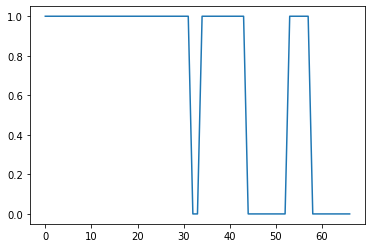

In [0]:
import matplotlib.pyplot as plt
plt.plot(window_labels)

## Processing & Saving loop

In [0]:
## Processing loop

seconds = 3 # Windowed time section in seconds 3 = 50Hz
overlap = 1/3 # 1/3 = 1s = 50Hz
target1 = 'on_off' 
target2 = 'dyskinesia'
target3 = 'tremor'
#col_names = ['X','Y','Z']

res_path = "/content/drive/My Drive/CA683_Assignment-2/Data/Extracted_Features/Windowed/"

#User loop for each user file in the raw savedir
for file in files: 
  user_id = file.split('.')[0]
  df_full = pd.read_csv(str(savedir + str(user_id)) + ".csv",index_col=0)
  measurement_list = list(df_full['measurement_id'].unique())
  print('\n Running for user: ' + str(user_id))

  #Sample frequency of sensor from Timestamp
  if df_full.Timestamp[75] > 1.0:
    Fs = 50
  else:
    Fs = 100

  print('Sample freq =  ' + str(Fs))
  window_size= seconds * Fs #seconds
  start_point=0
  overlap_win = int((window_size - start_point) * overlap)
  try:
    del df_full['Unnamed: 0']
  except:
    print('No Unnamed: 0')
  try:
    del df_full['Unnamed: 0.1']
  except:
    print('No Unnamed: 0.1')
  #Make user's plot folder
  save_path = res_path + str(user_id) +'/'
  try: 
    os.mkdir(save_path) 
  except OSError as error: 
    print(error) 
  #files_user = [f for f in listdir(save_path) if isfile(join(save_path, f))]

  #Check for processed measurements in save dir
  procfiles = [f for f in listdir(save_path) if isfile(join(save_path, f))]
  proc_meas = [i.split('.')[0] for i in procfiles] 
  rem_measurements = set(df_full.measurement_id) - set(proc_meas)

  #Iterate through the user's measurements and save processed windowed features in a loop
  for meas in rem_measurements:
    print('Measurement: ' +str(meas))
    df = df_full[df_full['measurement_id']==str(meas)]
    #Setup vars and dfs
    meas_df = []
    df_user = []
    feature_dict = []
    gait_feats = []
    gait_times =[]
    rest_trem = []
    rest_trem_times = []
    amp_rest_tremor = []
    amp_rest_trem_times = []
    hand_feature_times = []
    hand_amp = []
    hand_jerk = []
    hand_flag = []
    hand_flag_times = []
    count = 1

    #Windowed loop to extract features and then progress with overlap
    for start_point in tqdm(range(0,len(df.Timestamp),overlap_win)):
      clear_output(wait=True)

      #Window the dataframe to segment
      end_point = start_point+window_size
      if end_point > len(df.Timestamp):
        start_point = start_point - Fs*2
        end_point = len(df.Timestamp)
      df_slice = df.iloc[start_point:end_point]  #creates a dataframe with data between start_point and end_point (i.e. creates df with 400 records)
      df_slice = df_slice.reset_index(drop=True)

      #Custom feature extraction with DSP
      feature_df, df_res = custom_feature_extraction(df_slice, Fs, window_size)
      df_res['Window'] = count
      feature_df['Window'] = count
      count = count+1
      df_user.append(df_res)
      feature_dict.append(feature_df)

      #Gait Classifier
      gait_df, gait_time = build_gait_classification_feature_set(df_slice.loc[:, ['Timestamp', 'X', 'Y', 'Z']], Fs, seconds)   
      gait_times.append(gait_time[0].astype('int'))
      gait_feats.append(gait_df)

      #Resting Tremor
      feature_rest_trem, time_df_rest_trem = build_rest_tremor_classification_feature_set(df_slice.loc[:, ['Timestamp', 'X', 'Y', 'Z']], Fs, seconds)   
      rest_trem_times.append(time_df_rest_trem[0].astype('int'))
      rest_trem.append(feature_rest_trem)

      #Hand movement features
      amplitude, jerk, time_df_hand = calculate_amplitude_and_smoothness_features(df_slice.loc[:, ['Timestamp', 'X', 'Y', 'Z']], Fs, seconds)   
      hand_feature_times.append(time_df_hand[0].astype('int'))
      hand_amp.append(amplitude[0])
      hand_jerk.append(jerk[0])

      #Hand movement flag
      hand_labels, hand_times = detect_hand_movement(df_slice.loc[:, ['Timestamp', 'X', 'Y', 'Z']], Fs, seconds)   
      hand_flag_times.append(hand_times[0].astype('int'))
      hand_flag.append(hand_labels[0].astype('int'))

      time.sleep(0.01)

    #Dataframe conversion
    DSP = pd.DataFrame(pd.concat(df_user))
    DSP['Timestamp'] = DSP.Timestamp//1
    hand_df = pd.DataFrame(list(zip(hand_flag_times, hand_flag, hand_amp, hand_jerk)),
                columns=['Timestamp','hand_movement', 'hand_amp','hand_jerk'])
    gaits = pd.DataFrame(gait_times, columns=['Timestamp'])
    gaits['Timestamp'] = gaits.Timestamp//1
    gait = pd.concat(gait_feats, ignore_index=True)
    gait['Timestamp'] = gaits
    trem_ts = pd.DataFrame(rest_trem_times, columns=['Timestamp'])
    trem_ts['Timestamp'] = trem_ts.Timestamp//1
    trem_df = pd.concat(rest_trem, ignore_index=True)
    trem_df['Timestamp'] = trem_ts
    meas_df= DSP.merge(gait,on='Timestamp').merge(trem_df,on='Timestamp').merge(hand_df, on='Timestamp')
    
    #Save to csv
    print('OutPutting to csv')
    value1 = stats.mode(df_slice[target1].unique())[0][0]
    value2 = stats.mode(df_slice[target2].unique())[0][0]
    value3 = stats.mode(df_slice[target3].unique())[0][0]
    picture_id = "{}to{}".format(start_point,end_point)
    path = '{}{}.csv'.format(save_path,meas)
    meas_df.to_csv(path)